<a href="https://colab.research.google.com/github/alisonsoong/NASA-SEES-Internship-2021/blob/main/Estimated_Population_Directly_Affected_by_Wildfires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by Alison Soong


Algorithm ideas:
- https://www.ci.richmond.ca.us/DocumentCenter/View/53610/City-of-Richmond-Wildfire-Preparedness-and-Evacuation-Guide "A home within 10 miles of a wildfire will most likely be effected by wind driven embers which can be a risk to your property" --> might be a good buffer area to look at, but would need to convert burn scar area into a geometry (?)


Datasets:
- https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop#bands
- https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD64A1

References:
- https://colab.research.google.com/github/giswqs/geemap/blob/master/examples/notebooks/00_geemap_key_features.ipynb#scrollTo=zduDFJXjyeiz

# Import libraries

In [1]:
import ee # Import Earth Engine API

In [2]:

## Trigger the authentication flow. You only need to do this once
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=aG2J7vQf3Z_sXpHUdmLbCuukZjpZJEMkUcytxTWnmdU&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWisg8muWPc1UiqbfIzTMsINyo6X4y0FGvEhzTSBJ-B-0P2Pc8Yp27g

Successfully saved authorization token.


In [3]:
# Installs geemap package
import subprocess

try:
    import geemap
    print("geemap is imported and ready to use in Colab")
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])
    import geemap
    print("geemap is now installed, imported and ready to use in Colab") 


geemap package not installed. Installing ...
geemap is now installed, imported and ready to use in Colab


In [4]:
try:
    import ee
    import seaborn as sns
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print("package not found, installing w/ pip in Google Colab...")
        !pip install geemap seaborn matplotlib
    else:
        print("package not found, installing w/ conda...")
        !conda install mamba -c conda-forge -y
        !mamba install geemap -c conda-forge -y
        !conda install seaborn matplotlib -y
    import ee
    import seaborn as sns
    import matplotlib.pyplot as plt

In [108]:
try:
  import numpy as np
  import geemap
  import ee
  import seaborn as sns
  import matplotlib.pyplot as plt
  ee.Initialize()
except Exception as e:
  ee.Authenticate()
  ee.Initialize()

# Looking at populations and burn scars (burn areas)


Here is some information found about using gt an lt to specify a range, like you ask.

```
# Only keep pixels where population is greater than 0
# This might not work on your dataset.
populated2020 = pop2020.updateMask(pop2020.gt(0.0))
```

If you need to define a range instead, you could do this 
```
onlyWater = classified.updateMask(classified.gt(1).and(classified.lt(3))
```

eq() - equals
neq() - not equals
lt() - less than 
gt() - greater than
lte() - less than or equals
gte() - greater than or equals
and() - logical and
or() - logical or

In [5]:

import os
california_area = ee.FeatureCollection("TIGER/2018/States").filter(ee.Filter.eq('NAME', 'California'))



In [6]:
# population grid
popdataset2020 = ee.ImageCollection("WorldPop/GP/100m/pop")\
    .filterDate("2020-01-01", "2021-01-01")

pop2020 = popdataset2020.mean().clip(california_area)

pop_params = {
  'bands': ['population'],
  'min': 1.0,
  'max': 60.0,
  'palette' : ['bdd7e7','6baed6','2171b5']
}


In [7]:
# burned
burnedCollection2020 = ee.ImageCollection('MODIS/006/MCD64A1').filter(ee.Filter.date('2020-01-01', '2021-01-01'))

burned2020 = burnedCollection2020.select('BurnDate').mean().clip(california_area)

burned_params = {
  'min': 30.0,
  'max': 341.0,
  'palette':['red']
}

In [42]:
# reduce population grid to only burned areas, and add values
def mask(image):
  empty = 0
  qa = image.select('population');
  popMask = qa.neq(0) # masking out areas that have 0 population
  burnedMask = burned2020.select('BurnDate').neq(0) # masking out areas that were not burned
  mask = popMask.And(burnedMask) # only keep areas that were both burned and have a population
  return image.updateMask(mask).select("population").copyProperties(image, ['population'])

burnedpop2020 = popdataset2020.map(mask)

impacted_pop_params = {
  'bands': ['population'],
  'min': 0.0,
  'max': 60.0,
  'palette' : ['white','bdd7e7','6baed6','2171b5']
}

# not exactly sure what's going wrong here?
popSum = burnedpop2020.reduce(ee.Reducer.sum())

sumDictionary = popSum.reduceRegion(**{
  'reducer': ee.Reducer.sum(),
  'geometry': california_area,
  'scale': 100,
  'maxPixels': 1e12
})

print('Population affected in 2020:', sumDictionary.getInfo()['population_sum'])

totalPopSum = pop2020.reduce(ee.Reducer.sum())

sumTotalDictionary = totalPopSum.reduceRegion(**{
  'reducer': ee.Reducer.sum(),
  'geometry': california_area,
  'scale': 100,
  'maxPixels': 1e12
})

# Map = geemap.Map()
# Map.addLayer(burnedpop2020, impacted_pop_params, 'Impacted')
# Map.addLayer(burned2020, burned_params, 'Burned')
# Map.addLayerControl()
# Map

print('Total population in California 2020:', sumTotalDictionary.getInfo()['sum'])

print('Percent of population affected by wildfires in 2020:\n ', sumDictionary.getInfo()['population_sum']/sumTotalDictionary.getInfo()['sum']*100, '%', sep='')


Population affected in 2020: 28111.26220767843
Total population in California 2020: 35521219.45021494
Percent of population affected by wildfires in 2020:
 0.07913935006391884%


In [73]:
curBurned = ee.ImageCollection('MODIS/006/MCD64A1').filter(ee.Filter.date('2018-01-01', '2019-01-01')).mean().clip(california_area)
result = {"affected":[],"total":[],"percent":[], "year": []};

# reduce population grid to only burned areas, and add values
def maskProcess(image):
  qa = image.select('population');
  popMask = qa.neq(0) # masking out areas that have 0 population
  global curBurned
  burnedMask = curBurned.select('BurnDate').neq(0) # masking out areas that were not burned
  mask = popMask.And(burnedMask) # only keep areas that were both burned and have a population
  return image.updateMask(mask).select("population").copyProperties(image, ['population'])

# Map2 = geemap.Map()

def process(year):
    firstDate = str(year)+'-01-01'
    secondDate = str(year+1)+'-01-01'
    popdataset = ee.ImageCollection("WorldPop/GP/100m/pop").filterDate(firstDate, secondDate)
    pop = popdataset.mean().clip(california_area)
    burnedCollection = ee.ImageCollection('MODIS/006/MCD64A1').filter(ee.Filter.date(firstDate, secondDate))
    global curBurned
    curBurned = burnedCollection.select('BurnDate').mean().clip(california_area)
    burnedpop = popdataset.map(maskProcess)
    # Map2.addLayer(curBurned, burned_params, 'Burned Area ' + str(year), False, 0.6)
    # Map2.addLayer(pop, pop_params, 'pop ' + str(year), False)
    # Map2.addLayer(burnedpop, impacted_pop_params, 'Impacted Population ' + str(year), False) 
    popSum = burnedpop.reduce(ee.Reducer.sum())
    sumDictionary = popSum.reduceRegion(**{
      'reducer': ee.Reducer.sum(),
      'geometry': california_area,
      'scale': 100,
      'maxPixels': 1e12
    })
    totalPopSum = pop.reduce(ee.Reducer.sum())
    sumTotalDictionary = totalPopSum.reduceRegion(**{
      'reducer': ee.Reducer.sum(),
      'geometry': california_area,
      'scale': 100,
      'maxPixels': 1e12
    })
    # print(year)
    # print('Population affected: ', sumDictionary.getInfo()['population_sum'], sep='')
    # print('Total population in California: ', sumTotalDictionary.getInfo()['sum'], sep='')
    # print('Percent of population affected by wildfires: ', sumDictionary.getInfo()['population_sum']/sumTotalDictionary.getInfo()['sum']*100, '%', sep='')
    global result
    result['affected'].append(int(sumDictionary.getInfo()['population_sum']))
    result['total'].append(int(sumTotalDictionary.getInfo()['sum']))
    result['percent'].append(sumDictionary.getInfo()['population_sum']/sumTotalDictionary.getInfo()['sum']*100)
    result['year'].append(int(year))

# Map it
roi = ee.Geometry.Point(-122.438005, 37.729844) # (long, lat)

# Map2.add_basemap("SATELLITE")

# legend for population
legend_dict = {
    'No population': '000000',
    'Low population':'6baed6',
    'High population': '2171b5',
    'Area with population affected by wildfires': 'ffffff',
    'Burn areas': 'ff0000'
}

# Map2.add_legend(legend_title="Population and Burn Scars", legend_dict=legend_dict)

for i in range(2000,2021):
  process(i)

print(result['affected'])
print(result['total'])
print(result['percent'])
print(result['year'])

# Map2.centerObject(roi, 6)
# Map2.addLayerControl()
# Map2

# # we create a figure with pyplot and set the dimensions to 15 x 7
# fig, ax = plt.subplots(figsize=(15,7))

# # we'll create the plot by setting our dataframe to the data argument
# sns.lineplot(data=df, ax=ax)

# # we'll set the labels and title
# ax.set_ylabel('estimated population directly affected',fontsize=20)
# ax.set_xlabel('date',fontsize=20)
# ax.set_title('Yearly Population Directly Affected by Wildfires',fontsize=20);


[11, 5884, 3502, 57035, 7762, 8615, 5895, 44939, 31220, 24150, 1908, 1297, 684, 7203, 9423, 7620, 7002, 63678, 70648, 19699, 28111]
[29137226, 29406597, 29680576, 29959237, 30242692, 30530239, 30823665, 31122485, 31425782, 31734751, 32047985, 32367664, 32692120, 33023132, 33360967, 33704305, 34054437, 34410745, 34774456, 35143968, 35521219]
[4.096482834400055e-05, 0.020012376435003677, 0.011802133268174751, 0.190375890545677, 0.0256680199924441, 0.02821866191825336, 0.01912714380927015, 0.1443963462463478, 0.09934581998079074, 0.0761014342062153, 0.005954472077444485, 0.004009197996711395, 0.00209512631282397, 0.021813406615140536, 0.028247856431884044, 0.022609380656061585, 0.020562325187759127, 0.18505374387873985, 0.20316141801515886, 0.05605506454989155, 0.07913935006391884]
[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [ ]:
# [11, 5884, 3502, 57035, 7762, 8615, 5895, 44939, 31220, 24150, 1908, 1297, 684, 7203, 9423, 7620, 7002, 63678, 70648, 19699, 28111]
# [29137226, 29406597, 29680576, 29959237, 30242692, 30530239, 30823665, 31122485, 31425782, 31734751, 32047985, 32367664, 32692120, 
#         33023132, 33360967, 33704305, 34054437, 34410745, 34774456, 35143968, 35521219]
# [4.096482834400055e-05, 0.020012376435003677, 0.011802133268174751, 0.190375890545677, 0.0256680199924441, 0.02821866191825336, 
#         0.01912714380927015, 0.1443963462463478, 0.09934581998079074, 0.0761014342062153, 0.005954472077444485, 0.004009197996711395, 
#         0.00209512631282397, 0.021813406615140536, 0.028247856431884044, 0.022609380656061585, 0.020562325187759127, 0.18505374387873985, 
#         0.20316141801515886, 0.05605506454989155, 0.07913935006391884]
# [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [137]:
from google.colab import files


In [ ]:
# results so I don't have to run above code again!
# result['affected'] = [11, 5884, 3502, 57035, 7762, 8615, 5895, 44939, 31220, 24150, 1908, 1297, 684, 7203, 9423, 7620, 7002, 63678, 70648, 19699, 28111]
# result['total'] = [29137226, 29406597, 29680576, 29959237, 30242692, 30530239, 30823665, 31122485, 31425782, 31734751, 32047985, 32367664, 32692120, 33023132, 33360967, 33704305, 34054437, 34410745, 34774456, 35143968, 35521219]
# result['percent'] = [4.096482834400055e-05, 0.020012376435003677, 0.011802133268174751, 0.190375890545677, 0.0256680199924441, 0.02821866191825336, 0.01912714380927015, 0.1443963462463478, 0.09934581998079074, 0.0761014342062153, 0.005954472077444485, 0.004009197996711395, 0.00209512631282397, 0.021813406615140536, 0.028247856431884044, 0.022609380656061585, 0.020562325187759127, 0.18505374387873985, 0.20316141801515886, 0.05605506454989155, 0.07913935006391884]
# result['year'] = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

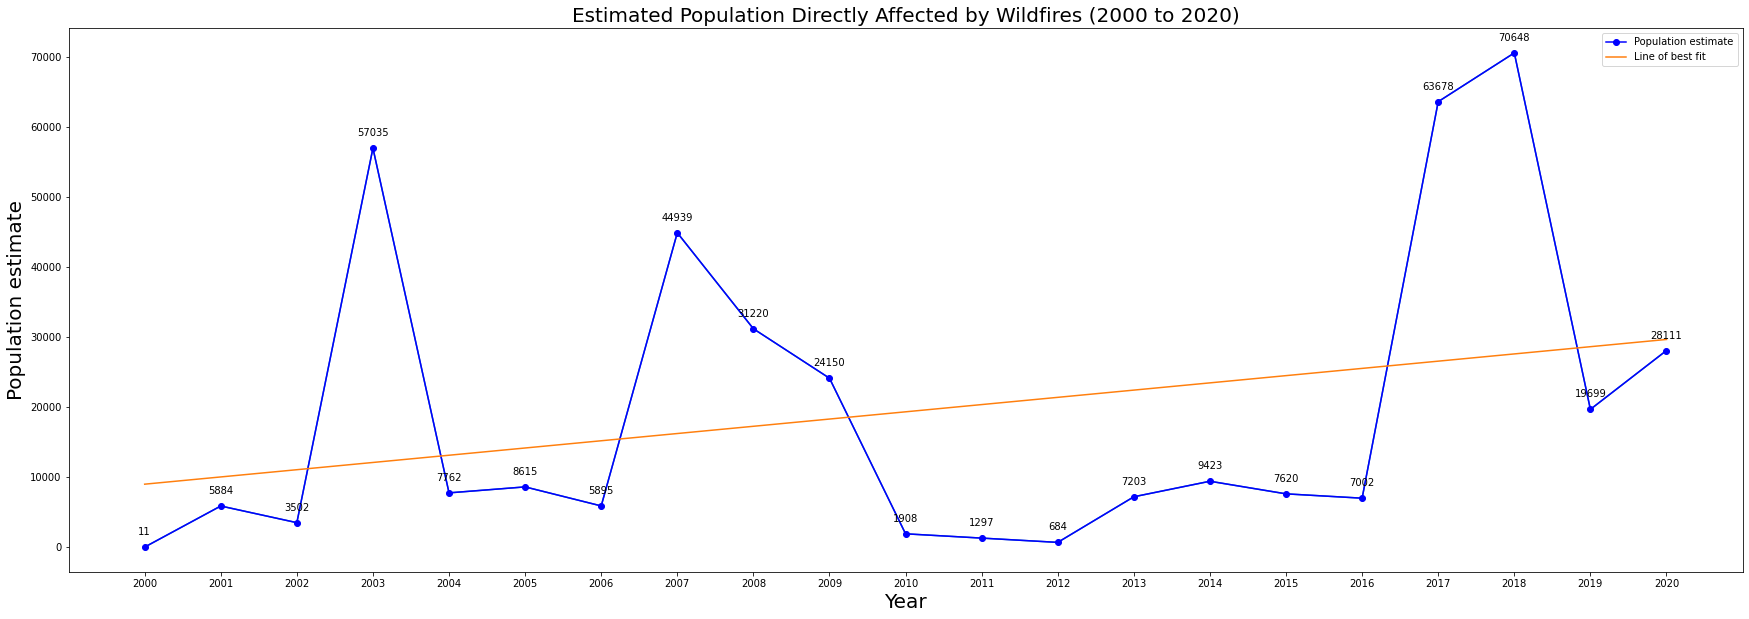

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [150]:
# # we create a figure with pyplot and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(30,10))

# we'll create the plot by setting our dataframe to the data argument
sns.lineplot(x=result['year'],y=result['affected'], ax=ax)

plt.xticks(np.arange(2000, 2020+1, 1.0))

# we'll set the labels and title
ax.set_ylabel('Population estimate',fontsize=20)
ax.set_xlabel('Year',fontsize=20)
ax.set_title('Estimated Population Directly Affected by Wildfires (2000 to 2020)',fontsize=20);

plt.plot(result['year'],result['affected'],'bo-', label='Population estimate')

# zip joins x and y coordinates in pairs
for x,y in zip(result['year'],result['affected']):

    label = y

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,12), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

x = np.arange(2000, 2020+1, 1.0)

y = result['affected']

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, label='Line of best fit')
ax.legend(loc='best')
plt.savefig('popEstimate.pdf', dpi=100)
plt.show()
plt.draw()
files.download('popEstimate.pdf')

Something I might look more into: edge detection -> https://developers.google.com/earth-engine/guides/image_edges

In [ ]:
# Map it
roi = ee.Geometry.Point(-122.438005, 37.729844) # (long, lat)

Map = geemap.Map()
Map.add_basemap("SATELLITE")

Map.addLayer(pop2020, pop_params, "Population 2020", True)
Map.addLayer(burned2020, burned_params, 'Burned Area 2020', True, 0.6)
Map.addLayer(burnedpop2020, impacted_pop_params, "Impacted Population 2020", True)
roi = ee.Geometry.Point(-122.438005, 37.729844) # (long, lat)

# legend for population
legend_dict = {
    'No population': '000000',
    'Low population':'6baed6',
    'High population': '2171b5',
    'Area with population affected by wildfires': 'ffffff',
    'Burn areas': 'ff0000'
}

Map.add_legend(legend_title="Population and Burn Scars", legend_dict=legend_dict)

Map.centerObject(roi, 6)
Map.addLayerControl()
Map